In [117]:
# tools
import pandas as pd
# plot
from matplotlib import pyplot as plt
# functions
from math import floor
from pathlib import Path
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter, CoxPHFitter

In [2]:
clicks = Path('../data/raw/clicks.csv.gzip')

In [3]:
clicks = pd.read_csv(clicks, compression='gzip')

In [89]:
clicks.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
0,2,NaN,4,2019-03-06T22:42:12.755Z,6333597102633388268,1.205689,1.070234,False,1.0,iGgClCM9exiHF4K31g94XmvHEBSLKIY,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,1.563,0.905,0.078,1891515180541284343,1904083516767779093
1,0,NaN,0,2019-03-08T10:24:30.641Z,6333597102633388268,1.218924,1.071209,False,4.0,MMHTOJ6qKAOeIH_Eywh1KIcCaxtO9oM,3.025219e+18,NaN,1.774085e+18,392184377613098015,NaN,NaN,NaN,NaN,1891515180541284343,3086509764961796666
2,0,NaN,0,2019-03-08T15:24:16.069Z,6333597102633388268,1.205689,1.070234,False,6.0,vIrEIdf9izUaWdAri6Ezk7T3nHFvNQU,5.975656e+18,NaN,3.072849e+18,392184377613098015,NaN,NaN,0.946,0.473,1891515180541284343,6958163894863846647
3,2,NaN,3,2019-03-06T03:08:51.543Z,6333597102633388268,1.205689,1.070234,False,45.0,YaKxxEAs2UmZhSpRfiCO9Zpa82B_AKM,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,19.013,0.035,0.431,1891515180541284343,4368617728156436525
4,2,NaN,3,2019-03-06T03:32:55.570Z,6333597102633388268,1.205689,1.070234,False,45.0,X5XTOcYQovkl6yadYdAD7xioVGU9jiY,6.768137e+18,NaN,3.072849e+18,2733035977666442898,NaN,28.110,0.054,0.423,1891515180541284343,4368617728156436525


In [91]:
def assign_event(t):
    return 1 if t <= (30) else 0

In [92]:
survival = (clicks.loc[:, ['timeToClick', 'brand']]
                  .fillna({'timeToClick': 999})
                  .assign(timeToClick = lambda df: df.timeToClick.map(floor),
                          E = lambda df: df.timeToClick.map(assign_event))
                  .rename(columns={'timeToClick': 'T'})
                  .query("T < 30"))

In [101]:
T1, E1 = survival.loc[lambda df: df.brand==2]['T'], survival.loc[lambda df: df.brand==2]['E']
T2, E2 = survival.loc[lambda df: df.brand==0]['T'], survival.loc[lambda df: df.brand==0]['E']
T3, E3 = survival.loc[lambda df: df.brand==1]['T'], survival.loc[lambda df: df.brand==1]['E']

In [103]:
kmf = KaplanMeierFitter()

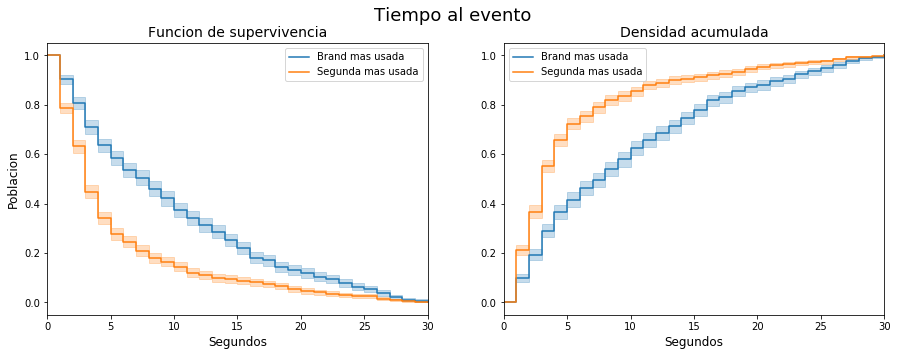

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
kmf.fit(T1 + 1, event_observed=E1, label='Brand mas usada')
kmf.plot_survival_function(ax=ax1)
kmf.plot_cumulative_density(ax=ax2)
kmf.fit(T2 + 1, event_observed=E2, label='Segunda mas usada')
kmf.plot_survival_function(ax=ax1)
kmf.plot_cumulative_density(ax=ax2)
fig.suptitle('Tiempo al evento', size=18)
ax1.set_title('Funcion de supervivencia', size=14)
ax1.set_xlabel('Segundos', size=12)
ax1.set_ylabel('Poblacion', size=12)
ax2.set_title('Densidad acumulada', size=14)
ax2.set_xlabel('Segundos', size=12)
plt.savefig('../assets/sf.png');
plt.savefig('../assets/sf.svg');
plt.show()

In [123]:
survival = survival.loc[lambda df: df.brand.isin([2,0])].replace({'brand':2.0}, 1)

In [124]:
cph = CoxPHFitter()
cph.fit(survival.dropna(), 'T', event_col='E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2556 observations, 0 censored>
      duration col = 'T'
         event col = 'E'
number of subjects = 2556
  number of events = 2556
    log-likelihood = -17409.13
  time fit was run = 2019-04-17 14:01:49 UTC

---
       coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
brand -0.55      0.57      0.04 -13.69 <0.005    139.21       -0.63       -0.47
---
Concordance = 0.60
Log-likelihood ratio test = 189.20 on 1 df, -log2(p)=140.59


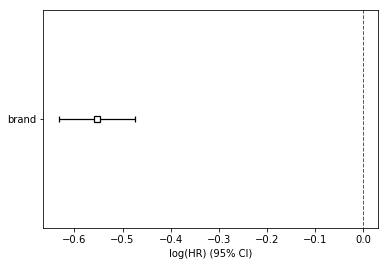

In [126]:
cph.plot()